In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers


In [6]:
data = pd.read_csv('/kaggle/input/smart-meter-electricity-consumption-dataset/smart_meter_data.csv')
print(data.head())
print(data.info())


             Timestamp  Electricity_Consumed  Temperature  Humidity  \
0  2024-01-01 00:00:00              0.457786     0.469524  0.396368   
1  2024-01-01 00:30:00              0.351956     0.465545  0.451184   
2  2024-01-01 01:00:00              0.482948     0.285415  0.408289   
3  2024-01-01 01:30:00              0.628838     0.482095  0.512308   
4  2024-01-01 02:00:00              0.335974     0.624741  0.672021   

   Wind_Speed  Avg_Past_Consumption Anomaly_Label  
0    0.445441              0.692057        Normal  
1    0.458729              0.539874        Normal  
2    0.470360              0.614724        Normal  
3    0.576241              0.757044        Normal  
4    0.373004              0.673981        Normal  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Timestamp             5000 non-null   object 
 1

In [7]:
# Convert Timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Extract temporal features
data['month'] = data['Timestamp'].dt.month
data['day_of_week'] = data['Timestamp'].dt.dayofweek
data['hour'] = data['Timestamp'].dt.hour
data['season'] = data['month'].apply(lambda x: (x % 12 + 3) // 3)  # 1=Winter, 2=Spring, 3=Summer, 4=Fall

# Lag features (prior consumption values)
data['lag_1'] = data['Electricity_Consumed'].shift(1).fillna(method='bfill')
data['lag_2'] = data['Electricity_Consumed'].shift(2).fillna(method='bfill')
data['lag_3'] = data['Electricity_Consumed'].shift(3).fillna(method='bfill')

# Rolling mean and std (window=3)
data['roll_mean_3'] = data['Electricity_Consumed'].rolling(window=3).mean().fillna(method='bfill')
data['roll_std_3'] = data['Electricity_Consumed'].rolling(window=3).std().fillna(method='bfill')

# Add fixed pdf-inspired feature example (contract demand)
contract_demand = 320  # Example constant, replace if you have real values
data['contract_demand'] = contract_demand

# Feature columns
features = ['Temperature', 'Humidity', 'Wind_Speed', 'Avg_Past_Consumption', 'month', 'hour', 'season',
            'lag_1', 'lag_2', 'lag_3', 'roll_mean_3', 'roll_std_3', 'contract_demand']

X = data[features]
y = data['Electricity_Consumed']  # Predict current consumption


/tmp/ipykernel_36/154920877.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['lag_1'] = data['Electricity_Consumed'].shift(1).fillna(method='bfill')
/tmp/ipykernel_36/154920877.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['lag_2'] = data['Electricity_Consumed'].shift(2).fillna(method='bfill')
/tmp/ipykernel_36/154920877.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['lag_3'] = data['Electricity_Consumed'].shift(3).fillna(method='bfill')
/tmp/ipykernel_36/154920877.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['roll_mean_3'] = data['Electricity_Consumed'].rolling(window=3).mean().fillna(method

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [9]:
split_idx = int(len(data) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [10]:
input_dim = X_train.shape[1]

model = Sequential([
    Input(shape=(input_dim,)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

model.summary()


2025-09-12 07:24:15.748256: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,801 (175.00 KB)

 Trainable params: 44,801 (175.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2632 - mae: 0.2020 - val_loss: 0.1678 - val_mae: 0.1183 - learning_rate: 0.0010
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1488 - mae: 0.0930 - val_loss: 0.1071 - val_mae: 0.0583 - learning_rate: 0.0010
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1011 - mae: 0.0718 - val_loss: 0.0715 - val_mae: 0.0440 - learning_rate: 0.0010
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0680 - mae: 0.0583 - val_loss: 0.0501 - val_mae: 0.0542 - learning_rate: 0.0010
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0457 - mae: 0.0493 - val_loss: 0.0317 - val_mae: 0.0277 - learning_rate: 0.0010
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0306 - mae: 0.0414 - val_loss: 0.0214 - val_mae: 0.0244 - learning_rate: 0.0010
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209 - mae: 0.0359 - val_loss: 0.0146 - val_mae: 0.0211 - learning_rate: 0.0010

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE: 0.000
MAE: 0.003
R2 Score: 0.999


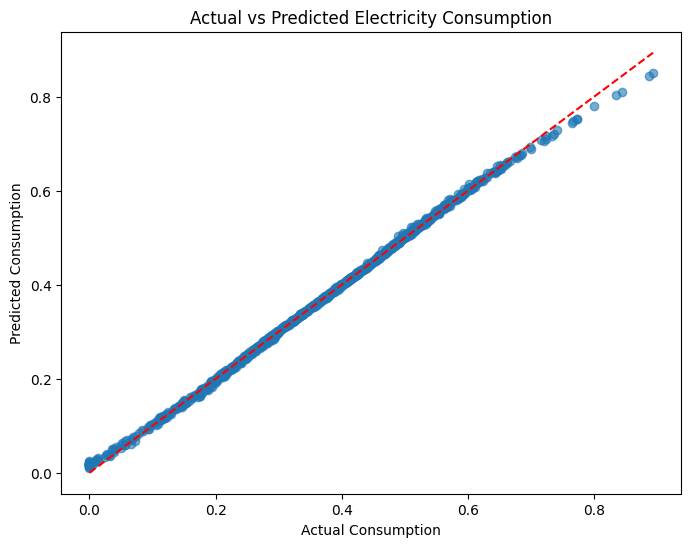

In [12]:
y_pred = model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'R2 Score: {r2:.3f}')

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Consumption')
plt.ylabel('Predicted Consumption')
plt.title('Actual vs Predicted Electricity Consumption')
plt.show()


Epoch 1/300


/tmp/ipykernel_36/4215996642.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['prev_consumption'] = df['Electricity_Consumed'].shift(1).fillna(method='bfill')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.4588 - mae: 0.5340 - val_loss: 0.0382 - val_mae: 0.1546 - learning_rate: 0.0010
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0468 - mae: 0.1694 - val_loss: 0.0302 - val_mae: 0.1366 - learning_rate: 0.0010
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0394 - mae: 0.1565 - val_loss: 0.0281 - val_mae: 0.1320 - learning_rate: 0.0010
Epoch 4/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0336 - mae: 0.1433 - val_loss: 0.0275 - val_mae: 0.1306 - learning_rate: 0.0010
Epoch 5/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0329 - mae: 0.1438 - val_loss: 0.0267 - val_mae: 0.1284 - learning_rate: 0.0010
Epoch 6/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0323 - mae: 0.1409 - val_loss: 0.0266 - val_mae: 0.1280 - learning_rate: 0.0010
Epoch 7/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0290 - mae: 0.1353 - val_loss: 0.0266 - val_mae: 0.1286 - learning_rate: 0.0010
Epoch 8/300
63/63 ━━━━━━━

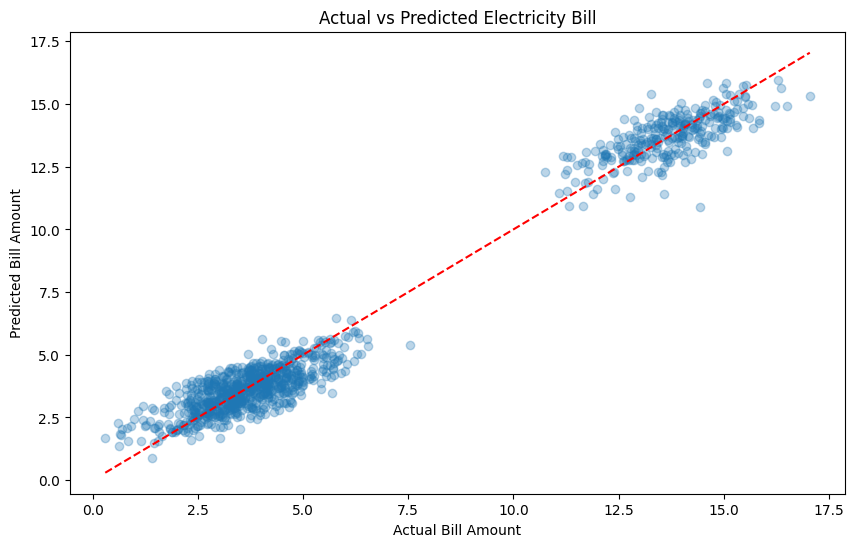

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load raw Kaggle data
df = pd.read_csv('/kaggle/input/smart-meter-electricity-consumption-dataset/smart_meter_data.csv')

# Convert Timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Feature engineering: lag value, plus time features
df['prev_consumption'] = df['Electricity_Consumed'].shift(1).fillna(method='bfill')
df['hour'] = df['Timestamp'].dt.hour
df['dayofweek'] = df['Timestamp'].dt.dayofweek
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

# Features used for model
features = [
    'Electricity_Consumed',
    'Temperature',
    'Humidity',
    'Wind_Speed',
    'Avg_Past_Consumption',
    'prev_consumption',
    'hour',
    'dayofweek',
    'is_weekend'
]

# Create realistic dummy target variable based on feature relationships
df['bill_amount'] = (
    df['Electricity_Consumed'] * 1.7 +
    df['Temperature'] * 5 -
    df['Humidity'] * 2 +
    df['Wind_Speed'] * 3 +
    10 * df['is_weekend'] +
    np.random.normal(0, 0.7, len(df))
)

# Prepare X and y
X = df[features].values
y = df['bill_amount'].values.reshape(-1, 1)

# Scale features and target
sc_X = StandardScaler()
X_scaled = sc_X.fit_transform(X)

sc_y = StandardScaler()
y_scaled = sc_y.fit_transform(y)

# Train-test split (hold out recent data)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Build more expressive ANN
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks for learning rate reduction and early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=300,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = sc_y.inverse_transform(y_pred)
y_test_inv = sc_y.inverse_transform(y_test)

# Compute metrics
print(f"MAE: {mean_absolute_error(y_test_inv, y_pred_inv):.3f}")
print(f"MSE: {mean_squared_error(y_test_inv, y_pred_inv):.3f}")
print(f"R2: {r2_score(y_test_inv, y_pred_inv):.3f}")

# Plot Actual vs Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.3)
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')
plt.xlabel("Actual Bill Amount")
plt.ylabel("Predicted Bill Amount")
plt.title("Actual vs Predicted Electricity Bill")
plt.show()
